In [1]:
## Import libraries. All of these packages are in the requirements.txt file accompanying this project. As best practice, 
## we recommend running this in an isolated venv.

import pandas as pd
import numpy as np
import os
import openpyxl
import ast
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx

#### Setup
These variables are global to set the geographies, year, database, for our analysis. 

In [2]:
## The geography_code is the census fips code in str format for the main geography for the rental housing needs assessment.
geography_city = '4819000'
geography_metro = 'c19100'
geography_county = '48113'
## The most recent year that the ACS / PUMS data is available. 
acs_year = 2022
## This report pulls from a database developed by HR&A for these functions. Each figure pulls from one or more tables in the database 
## and are in the format "prefix/"+SOURCE_TABLENAME_DESCRIPTION.csv

url_prefix = "https://housing-needs-assessment-data.s3.amazonaws.com/"

## The name of the geography, pulled from our crosswalk file
names = pd.read_csv('https://housing-needs-assessment-data.s3.amazonaws.com/resources/geo_relatedgeo_crosswalk.csv', converters={'geo_id':str})
geo_name = names[(names['geo_id'] == geography_city) & (~names['related_geo_id'].astype(str).str.startswith("p").fillna(False))]['geo_name'].iloc[0]

names = names.drop_duplicates(subset=['geo_id', 'geo_name'])[['geo_id','geo_name']]

#### Common Functions

In [3]:
def filter_dataset(dataset_name, geography_set, years):
    df = pd.read_csv(url_prefix+dataset_name+'.csv', converters = {'geo_id':str})
    df = df[(df['geo_id'].isin(geography_set)) & (df['year'].isin(years))]
    return df

def write_to_csv(source, section, folder, name):
    
    file_path = section + "_" + folder + "/" + name + ".csv"
    combined.to_csv(file_path, index=False)
    with open(file_path,'a') as f:
        f.write('\n'+"Source: " + source)

#### Figure 2: City of Dallas Population (1990-2022) [p.25]
Source: Decennial_Population (Census) and B01003 (American Communities Survey)

In [4]:
### Figure 2 combines decennial with ACS data for a historic review of population. 

df = filter_dataset(
    dataset_name = 'DECENNIAL_Population',
    geography_set = [geography_city],
    years = [1990,2000,2010]
)

xf = filter_dataset(
    dataset_name = 'ACS_B01003_Population',
    geography_set = [geography_city],
    years = [acs_year]
)

In [5]:
# join and merge dataframes
df = pd.concat([df, xf], ignore_index=True)
df = df.sort_values("year").reset_index(drop=True)
df = df.merge(names, on='geo_id')
df.drop(columns='geo_id',inplace=True)
df

,year,population,geo_name
0,1990,1006877,Dallas
1,2000,1188580,Dallas
2,2010,1197816,Dallas
3,2022,1300642,Dallas


In [6]:
### For easier chart creation, we pivot the data to have years as columns for Excel
xf = df.pivot(index='geo_name', columns='year', values='population')
xf = xf.reset_index()
xf

year,geo_name,1990,2000,2010,2022
0,Dallas,1006877,1188580,1197816,1300642


In [7]:
# export completed dataframe to folder
file_path = 'DO_completed_csvs/figure1_2.csv'
title = 'Source: Decennial 1990 & ACS 2022 Population'
xf.to_csv(file_path, index=False)

# append the data source to the dataframe
with open(file_path, 'a') as f:
    f.write('\n' + title)

#### Figure 3: Comparative Population Growth (1990-2022)[p.25]
Source: Decennial_Population (Census) and B01003 (American Communities Survey)

In [11]:
df = filter_dataset(
    dataset_name = 'DECENNIAL_Population',
    geography_set = [geography_city, geography_county, geography_metro],
    years = [1990,2000,2010]
)

xf = filter_dataset(
    dataset_name = 'ACS_B01003_Population',
    geography_set = [geography_city, geography_county, geography_metro],
    years = [2022]
)

In [12]:
# join and merge dataframes
df = pd.concat([df, xf], ignore_index=True)
df = df.sort_values("year").reset_index(drop=True)
df = df.merge(names, on='geo_id')
df

,geo_id,year,population,geo_name
0,48113,1990,1852810,Dallas County
1,4819000,1990,1006877,Dallas
2,c19100,1990,3984437,"Dallas-Fort Worth-Arlington, TX"
3,48113,2000,2218899,Dallas County
4,c19100,2000,5156217,"Dallas-Fort Worth-Arlington, TX"
5,4819000,2000,1188580,Dallas
6,48113,2010,2368139,Dallas County
7,4819000,2010,1197816,Dallas
8,c19100,2010,6366542,"Dallas-Fort Worth-Arlington, TX"
9,c19100,2022,7673379,"Dallas-Fort Worth-Arlington, TX"


In [13]:
#Calculate population growth

def calculate_index(row, base_pop):
    return 100 * row['population'] / base_pop

for geo_id in df['geo_id'].unique():
    base_pop = df[(df['geo_id'] == geo_id) & (df['year'] == 1990)]['population'].values[0]
    df.loc[df['geo_id'] == geo_id, 'index'] = df[df['geo_id'] == geo_id].apply(calculate_index, axis=1, base_pop=base_pop)
df['index'] = df['index'].astype(int)
df.drop(columns='geo_id',inplace=True)
df

,year,population,geo_name,index
0,1990,1852810,Dallas County,100
1,1990,1006877,Dallas,100
2,1990,3984437,"Dallas-Fort Worth-Arlington, TX",100
3,2000,2218899,Dallas County,119
4,2000,5156217,"Dallas-Fort Worth-Arlington, TX",129
5,2000,1188580,Dallas,118
6,2010,2368139,Dallas County,127
7,2010,1197816,Dallas,118
8,2010,6366542,"Dallas-Fort Worth-Arlington, TX",159
9,2022,7673379,"Dallas-Fort Worth-Arlington, TX",192


In [14]:
#pivot the dataframe 
xf = df.pivot(index='geo_name', columns='year', values=['population', 'index'])
xf = xf.reset_index()
xf

geo_name population                             \
year                                        1990     2000     2010     2022   
0                              Dallas    1006877  1188580  1197816  1300642   
1                       Dallas County    1852810  2218899  2368139  2604053   
2     Dallas-Fort Worth-Arlington, TX    3984437  5156217  6366542  7673379   

     index                 
year  1990 2000 2010 2022  
0      100  118  118  129  
1      100  119  127  140  
2      100  129  159  192

In [15]:
# export completed dataframe to folder
file_path = 'DO_completed_csvs/figure1_3.csv'
title = 'Source: Decennial 1990 & ACS 2022 Population'
xf.to_csv(file_path, index=True)

# append the data source to the dataframe
with open(file_path, 'a') as f:
    f.write('\n' + title)

#### Figure 4: City of Dallas Comparative Population Growth (1990-2022) Cities with population 500,000 or greater [p.26]
**Source:** Decennial_Population (Census) and B01003 (American Communities Survey)

**Note:** Place definitions have changed since 1990. We use a reference here named 1990_places to match the old definitions to new ones.

In [17]:
#pull data
file_path = 'references/1990_places.csv'
df = pd.read_csv(file_path)
pop = pd.read_csv(url_prefix + 'ACS_B01003_Population.csv', converters = {'geo_id':str})

In [18]:
# filter to only keep cities with population 500,000 or greater
pop = pop.merge(names, on='geo_id')
pop = pop[(pop['year'] == 2022) & (pop['geo_id'].str.len() == 7) & (pop['population'] >= 500000)]
pop = pop.rename(columns={'population':'pop2022'})

##Standardizing these names to match the 1990 data with current ACS data
geo_name = ['Fresno city, California', 'Los Angeles city, California', 'Mesa city, Arizona', 'Phoenix city, Arizona', 'Tucson city, Arizona', 'Sacramento city, California', 'San Diego city, California', 'San Francisco city, California', 'San Jose city, California', 'Denver city, Colorado', 'Washington city, District of Columbia', 'Jacksonville city (remainder), Florida', 'Chicago city, Illinois', 'Louisville city, Kentucky', 'Indianapolis city (remainder), Indiana', 'Baltimore city, Maryland', 'Boston city, Massachusetts', 'Detroit city, Michigan', 'Kansas City city, Missouri', 'Las Vegas city, Nevada', 'Albuquerque city, New Mexico', 'New York city, New York', 'Charlotte city, North Carolina', 'Columbus city, Ohio', 'Oklahoma City city, Oklahoma', 'Portland city, Oregon', 'Philadelphia city, Pennsylvania', 'Memphis city, Tennessee', 'Nashville-Davidson (remainder), Tennessee', 'Austin city, Texas', 'Dallas city, Texas', 'El Paso city, Texas', 'Fort Worth city, Texas', 'Houston city, Texas', 'San Antonio city, Texas', 'Seattle city, Washington', 'Milwaukee city, Wisconsin']
filtered_df = df[df['Geo_QName'].isin(geo_name)]
filtered_df['Standardized_Name'] = filtered_df['Geo_QName'].str.replace(' city', '', regex=False).str.replace(' (remainder)', '', regex=False).str.split(',').str[0]

/tmp/ipykernel_391350/431022363.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Standardized_Name'] = filtered_df['Geo_QName'].str.replace(' city', '', regex=False).str.replace(' (remainder)', '', regex=False).str.split(',').str[0]


In [19]:
# create temporary key columns for the first three characters
pop['temp_key'] = pop['geo_name'].str[:5]
filtered_df['temp_key'] = filtered_df['Standardized_Name'].str[:5]

# perform the merge based on the temporary keys
merged_df = pd.merge(pop, filtered_df, on='temp_key', how='inner')

# drop the temporary key columns
merged_df.drop('temp_key', axis=1, inplace=True)

/tmp/ipykernel_391350/1388576424.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['temp_key'] = filtered_df['Standardized_Name'].str[:5]


In [20]:
#calculate population growth
merged_df['population growth_prc'] = ((merged_df['pop2022'] - merged_df['pop1990']) / merged_df['pop1990'])*100
merged_df = merged_df.sort_values("population growth_prc", ascending = False).reset_index(drop=True)
merged_df.drop(columns=['geo_id', 'year', 'geo_name', 'Geo_NAME', 'Geo_FIPS', 'Standardized_Name'], inplace=True)
merged_df.sort_values('pop2022', ascending=False)

,pop2022,Geo_QName,pop1990,population growth_prc
25,8622467,"New York city, New York",7322564,17.752020
29,3881041,"Los Angeles city, California",3485398,11.351444
33,2721914,"Chicago city, Illinois",2783726,-2.220477
17,2296253,"Houston city, Texas",1630553,40.826640
6,1609456,"Phoenix city, Arizona",983403,63.661896
32,1593208,"Philadelphia city, Pennsylvania",1585577,0.481276
7,1445662,"San Antonio city, Texas",935933,54.462125
23,1383987,"San Diego city, California",1110549,24.621876
21,1300642,"Dallas city, Texas",1006877,29.175858
22,1001176,"San Jose city, California",782248,27.987032


In [21]:
# export completed dataframe to folder
file_path = 'DO_completed_csvs/figure1_4.csv'
title = 'Source: 1990 Census gazetteer files & ACS 2022 Population'
merged_df.to_csv(file_path, index=False)

# append the data source to the dataframe
with open(file_path, 'a') as f:
    f.write('\n' + title)

#### Figure 5: Dallas-Fort Worth Metro Comparative Population Growth (1990-2022) Metro Areas (CBSAs) with population 1,500,000 or greater [p.26]
**Source:** Decennial_Population (Census) and B01003 (American Communities Survey)

**Note:** Place definitions have changed since 1990. We use a reference here named 1990_places to match the old definitions to new ones.


In [22]:
# pull data
df = pd.read_csv(url_prefix + 'DECENNIAL_Population.csv', converters = {'geo_id':str})
xf = pd.read_csv(url_prefix + 'ACS_B01003_Population.csv', converters = {'geo_id':str})
## Crosswalk for Counties to CBSAS
xwalk = pd.read_csv(url_prefix + 'resources/county_cbsa_xwalk.csv', converters={'county': str, 'cbsa':str})

In [23]:
# filter acs population data to only keep CBSAs with population 1,500,000 or greater
xf = xf[(xf['year'] == 2022) & 
                 (xf['geo_id'].str.startswith('c')) & 
                 (xf['population'] >= 1500000)]
xf = xf.rename(columns={'population':'pop2022'})
cbsa_large_list = xf['geo_id'].unique().tolist()

# filter decennial population data to county-level
df = df[df['geo_id'].str.len()==5]
# merge in CBSA codes for counties within CBSAs
df = df.merge(xwalk, left_on='geo_id', right_on='county', how='inner') # inner merge so that only counties inside of CBSAs remain (and no counties outside CBSAs)
df = df.drop(columns=['geo_id', 'county'])
df = df.rename(columns={'cbsa':'geo_id', 'population':'pop1990'})

# groupby CBSA
df = df.groupby(['geo_id', 'year']).sum().reset_index()
df = df[df['year'].isin([1990])]
df = df[df['geo_id'].isin(cbsa_large_list)]

# merge dataframes on 'geo_id'
merged_df = pd.merge(xf, df, on="geo_id", how="inner")

# calculate population growth percentage
merged_df['growth_percentage'] = ((merged_df['pop2022'] - merged_df['pop1990']) / merged_df['pop1990']) * 100

# Display the merged dataFrame with the new column
merged_df = merged_df.sort_values(by='growth_percentage', ascending=False)
xwalk = pd.read_csv(url_prefix + 'resources/geo_relatedgeo_crosswalk.csv', converters={'geo_id':str})
xwalk = xwalk[['geo_id', 'geo_name']]
xwalk.drop_duplicates(inplace=True, keep='last')
merged_df = merged_df.merge(xwalk, on='geo_id')
merged_df.drop(columns=['geo_id', 'year_x', 'year_y'], inplace=True)
merged_df

,pop2022,pop1990,growth_percentage,geo_name
0,2265926,741459,205.603681,"Las Vegas-Henderson-Paradise, NV"
1,6123949,2119006,189.001022,"Miami-Fort Lauderdale-Pompano Beach, FL"
2,2296377,846227,171.366548,"Austin-Round Rock-Georgetown, TX"
3,2679298,1224852,118.744632,"Orlando-Kissimmee-Sanford, FL"
4,4864209,2238480,117.299641,"Phoenix-Mesa-Chandler, AZ"
5,6094752,3083843,97.634964,"Atlanta-Sandy Springs-Alpharetta, GA"
6,2668688,1365184,95.481928,"Charlotte-Concord-Gastonia, NC-SC"
7,7673379,3984437,92.583770,"Dallas-Fort Worth-Arlington, TX"
8,7142603,3767335,89.592988,"Houston-The Woodlands-Sugar Land, TX"
9,2570862,1407745,82.622705,"San Antonio-New Braunfels, TX"


In [24]:
# export completed dataframe to folder
file_path = 'DO_completed_csvs/figure1_5.csv'
title = 'Source: Decennial 1990 & ACS 2022 Population'
merged_df.to_csv(file_path, index=False)

# append the data source to the dataframe
with open(file_path, 'a') as f:
    f.write('\n' + title)

####  Figure 7: City of Dallas Household Size (2012-2022) [p.28]
**Source:**  B25009 (American Communities Survey)

**Note:** Place definitions have changed since 1990. We use a reference here named 1990_places to match the old definitions to new ones.

In [25]:
# pull data
df = filter_dataset(
    dataset_name = 'ACS_B25009_HouseholdSize',
    geography_set = [geography_city],
    years = [2012,2022]
)

In [26]:
df = df.merge(names, on='geo_id')

# transpose dataframe
df_pivoted = df.pivot(index='year', columns='household_size', values='households')
geo_name = df['geo_name'].iloc[0]
df_pivoted.columns = [f"{geo_name}_{col}" for col in df_pivoted.columns]
df_pivoted.reset_index(inplace=True)
df_pivoted


,year,Dallas_1_person_household,Dallas_2_person_household,Dallas_3_person_household,Dallas_4_person_household,Dallas_5_person_household,Dallas_6_person_household,Dallas_7_Inf_person_household,Dallas_all
0,2012,158396,129595,63345,53095,28925,13570,10045,456971
1,2022,191742,153849,66683,53630,33812,13032,8399,521147


In [27]:
# export completed dataframe to folder
file_path = 'DO_completed_csvs/figure1_7.csv'
title = 'Source: ACS 2012 & 2022 B25009_HouseholdSize'
df_pivoted.to_csv(file_path, index=False)

# append the data source to the dataframe
with open(file_path, 'a') as f:
    f.write('\n' + title)

####  Figure 8: Average Household Size (2012-2022) [p.28]
**Source:**  B25010 (American Communities Survey)

In [28]:
# pull data
df = filter_dataset(
    dataset_name = 'ACS_B25010_AverageHouseholdSize',
    geography_set = [geography_city,geography_metro,geography_county],
    years = [2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022]
)
xf = df.sort_values("year").reset_index(drop=True)
xf = xf.merge(names, on='geo_id')

# clean and pivot dataframe
pivot_df = xf.pivot(index='year', columns='geo_name', values='average_household_size')
pivot_df.reset_index(drop=True, inplace=True)
pivot_df

geo_name,Dallas,Dallas County,"Dallas-Fort Worth-Arlington, TX"
0,2.60,2.76,2.77
1,2.60,2.77,2.78
2,2.61,2.78,2.79
3,2.60,2.79,2.80
4,2.58,2.77,2.80
5,2.58,2.78,2.81
6,2.57,2.79,2.83
7,2.56,2.78,2.83
8,2.52,2.74,2.82
9,2.49,2.72,2.77


In [30]:
# export completed dataframe to folder
file_path = 'DO_completed_csvs/figure1_8.csv'
title = 'Source: ACS 2012 & 2022 B25009_HouseholdSize'
pivot_df.to_csv(file_path, index=True)

# append the data source to the dataframe
with open(file_path, 'a') as f:
    f.write('\n' + title)

#### Figure 9: Net Out-Migrants from Dallas County to other Metro Counties (2011-2021) [p.28]

**Source:** IRS Data (Next release is 6/27/24)

In [31]:
# Read the CSV file containing IRS data for out-migrants, ensuring 'geo_id' is read as string
df = pd.read_csv(url_prefix + '230912_IRS_Data_Top.csv', converters={'geo_id': str})

# Keep only the rows where the flow is 'outflow', indicating out-migration
df = df[df['flow'] == 'outflow']

# Define the geography of the county of interest
origin = [geography_county]

# Ensure the 'geo_id' column is of type string (this may be redundant due to the converter)
df['geo_id'] = df['geo_id'].astype(str)

# Filter the dataframe to include only the specified origin counties
df = df[df['geo_id'].isin(origin)]

# Ensure the 'related_geo_id' column is of type string
df['related_geo_id'] = df['related_geo_id'].astype(str)

# List of destination counties in Texas (as strings of their geo IDs)
destination = ['48121', '48085', '48231', '48439', '48397', '48257', '48139', '48251']

# Filter the dataframe to include only the specified destination counties
df = df[df['related_geo_id'].isin(destination)]

# Merge the dataframe with another dataframe 'names' to associate geo IDs with geographic names
df = df.merge(names, left_on='related_geo_id', right_on='geo_id')

# Calculate the number of out-migrant households using individual counts and average household size
df['out_hh'] = df['number_individuals'] / df['avg_hh_size']

# Group by geographic name and sum the out-migrant households for each destination
df = df.groupby('geo_name', as_index=False).agg({'out_hh': 'sum'})
df

,geo_name,out_hh
0,Collin County,231523.493497
1,Denton County,175383.245551
2,Ellis County,44254.229244
3,Hunt County,14021.775471
4,Johnson County,7512.823438
5,Kaufman County,53860.641419
6,Rockwall County,32770.163956
7,Tarrant County,241524.213093


/tmp/ipykernel_391350/133423578.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dallas_buffer = dallas_counties.centroid.buffer(35000)
/tmp/ipykernel_391350/133423578.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dallas_buffer = dallas_counties.centroid.buffer(35000)


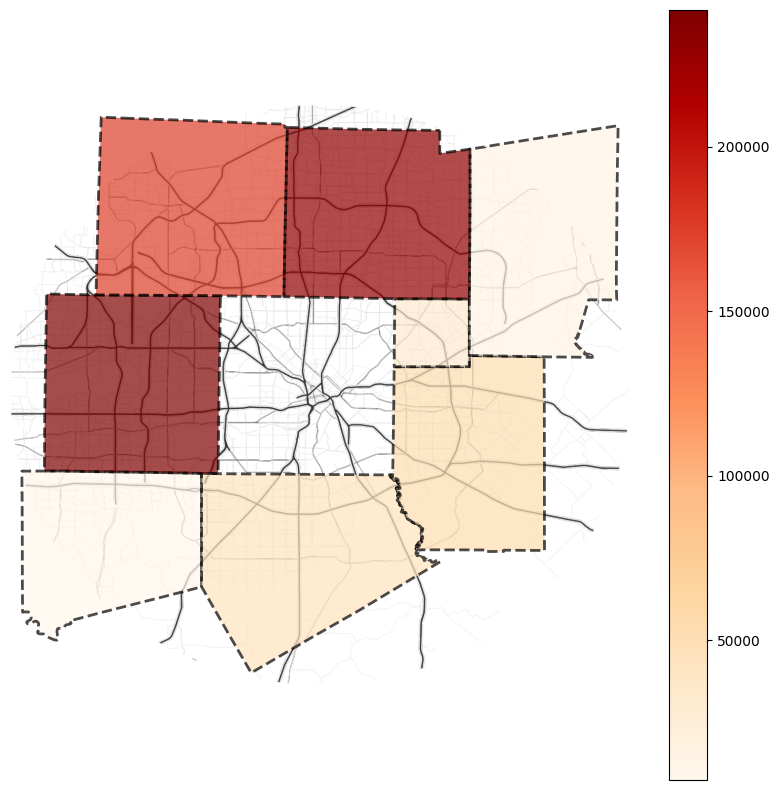

In [33]:
### This dataset will be mapped in the next step.

#buffer for map boundaries
dallas_counties = gpd.read_file('references/DFW_counties.shp')
dallas_counties['CNTY_NM'] = dallas_counties['CNTY_NM'] + ' County'
dallas_dissolve = dallas_counties.dissolve()
dallas_buffer = dallas_counties.centroid.buffer(35000)
factor = 8000

#basemap
bmap = 'references/masked_basemap.tif'

# Merge dataframe and shapefile on the county column
merged_gdf = dallas_counties.merge(df, left_on='CNTY_NM', right_on='geo_name')

# Ensure the CRS is set to EPSG:3857 for plotting with Contextily
merged_gdf = merged_gdf.to_crs(epsg=3857)

# Plot the choropleth map
fig, ax = plt.subplots(figsize=(10, 10))

merged_gdf.plot(ax=ax, alpha=0.7, edgecolor='black', 
                column='out_hh', cmap='OrRd',
                linewidth=2, linestyle ='dashed', legend=True)

# Calculate bounds for setting the view limits based on merged_gdf
minx, miny, maxx, maxy = merged_gdf.total_bounds
factor = 0.02 * (maxx - minx)  # Adjust factor for margins

ax.set_xlim(minx - factor, maxx + factor)
ax.set_ylim(miny - factor, maxy + factor)
ax.set_axis_off()

# Add a basemap
cx.add_basemap(ax, crs=merged_gdf.crs.to_string(), source=bmap, alpha=0.8)

In [34]:
# export completed dataframe to folder
file_path = 'DO_completed_csvs/figure1_9.csv'
title = 'Source: IRS 2021 Out-migrants by income'
df_pivoted.to_csv(file_path, index=False)

# append the data source to the dataframe
with open(file_path, 'a') as f:
    f.write('\n' + title)

#### Figure 10: Household size of in-migrants versus out-migrants (2021) [p.28]

**Source:** IRS Data


In [35]:
#### Figure 10: Household size of in-migrants versus out-migrants (2021) [p.28]

# pull data
df = pd.read_csv(url_prefix + '230912_IRS_Data_Top.csv', converters = {'geo_id':str})

## out-migrants: filter to 2021 & only outflow from Dallas County
out_df = df[(df['year'].isin([2021])) & (df['flow'] == 'outflow') & (df['geo_id'] == geography_county)]
out_df['out_hh'] = (out_df['number_individuals']) / (out_df['avg_hh_size'])

# in-migrants: filter to 2021 & only outflow from Dallas County
in_df = df[(df['year'].isin([2021])) & (df['flow'] == 'inflow')]
destination = [geography_county]
in_df['related_geo_id'] = in_df['related_geo_id'].astype(str)
in_df = in_df[in_df['related_geo_id'].isin(destination)]
in_df['in_hh'] = (in_df['number_individuals']) / (in_df['avg_hh_size'])

# calculate the mean of 'out_hh' from out_df
mean_out_hh = out_df['out_hh'].mean()

# calculate the mean of 'in_hh' from in_df
mean_in_hh = in_df['in_hh'].mean()

# create a new dataframe with these means
mean_df = pd.DataFrame({
    'mean_out_hh': [mean_out_hh],
    'mean_in_hh': [mean_in_hh]
})
mean_df

/tmp/ipykernel_391350/3966517186.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  out_df['out_hh'] = (out_df['number_individuals']) / (out_df['avg_hh_size'])
/tmp/ipykernel_391350/3966517186.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  in_df['related_geo_id'] = in_df['related_geo_id'].astype(str)


,mean_out_hh,mean_in_hh
0,2774.217093,508.769248


In [36]:
# export completed dataframe to folder
file_path = 'DO_completed_csvs/figure1_10.csv'
title = 'Source: IRS 2021 Out-migrants by income'
mean_df.to_csv(file_path, index=False)

# append the data source to the dataframe
with open(file_path, 'a') as f:
    f.write('\n' + title)

#### Figure 12: City of Dallas Age Distribution (2012-2022)[p.30]

**Source:** B01001 (American Communities Survey)

In [40]:
# pull data
df = filter_dataset(
    dataset_name = 'ACS_B01001_AgeDistribution',
    geography_set = [geography_city],
    years = [2012,2017,2022]
)
df = df[df['age_range'] != '25+']
df = df.merge(names, on='geo_id')

# map the existing age ranges to the new categories
age_mapping = {
    '0_17': '17 and under',
    '18_24': '18 to 34',
    '25_34': '18 to 34',
    '35_64': '35 to 64',
    '65_Inf': '65 and over'
}

# apply the mapping to the age_range column
df['age_cat'] = df['age_range'].map(age_mapping)

# group by the new age range and other relevant columns, and sum the population
grouped_df = df.groupby(['geo_name', 'year', 'age_cat'])['population'].sum().reset_index()

# calculate total population by year without merging it back
grouped_df['total_population'] = grouped_df.groupby('year')['population'].transform('sum')

# calculate the percentage
grouped_df['percentage'] = (grouped_df['population'] / grouped_df['total_population']) * 100

pivoted_df = grouped_df.pivot(index='age_cat', columns='year', values=['population', 'total_population', 'percentage'])
pivoted_df

population                     total_population             \
year               2012      2017      2022             2012       2017   
age_cat                                                                   
17 and under   316586.0  332020.0  317057.0        1207202.0  1300122.0   
18 to 34       350361.0  371496.0  372467.0        1207202.0  1300122.0   
35 to 64       431755.0  468984.0  467626.0        1207202.0  1300122.0   
65 and over    108500.0  127622.0  143492.0        1207202.0  1300122.0   

                        percentage                        
year               2022       2012       2017       2022  
age_cat                                                   
17 and under  1300642.0  26.224774  25.537603  24.376962  
18 to 34      1300642.0  29.022566  28.573934  28.637165  
35 to 64      1300642.0  35.764934  36.072307  35.953475  
65 and over   1300642.0   8.987725   9.816156  11.032398

In [41]:
# export completed dataframe to folder
file_path = 'DO_completed_csvs/figure1_12.csv'
title = 'Source: ACS 2012 & 2022 B01001_AgeDistribution'
pivoted_df.to_csv(file_path, index=True)

# append the data source to the dataframe
with open(file_path, 'a') as f:
    f.write('\n' + title)

#### Figure 13: Comparative Age Distribution (2022)[p.30]
**Source:** B01001 (American Communities Survey) 

In [43]:
# pull data
df = filter_dataset(
    dataset_name = 'ACS_B01001_AgeDistribution',
    geography_set = [geography_county,geography_city,geography_metro],
    years = [2022]
)
df = df[df['age_range'] != '25+']
df = df.merge(names, on='geo_id')

In [39]:
# map the existing age ranges to the new categories
age_mapping = {
    '0_17': '17 and under',
    '18_24': '18 to 34',
    '25_34': '18 to 34',
    '35_64': '35 to 64',
    '65_Inf': '65 and over'
}

# apply the mapping to the age_range column
df['age_cat'] = df['age_range'].map(age_mapping)

# group by the new age range and other relevant columns, and sum the population
grouped_df = df.groupby(['geo_name', 'year', 'age_cat'])['population'].sum().reset_index()

# calculate total population by year without merging it back
grouped_df['total_population'] = grouped_df.groupby('year')['population'].transform('sum')

# calculate the percentage
grouped_df['percentage'] = (grouped_df['population'] / grouped_df['total_population']) * 100

pivoted_df = grouped_df.pivot(index='age_cat', columns='year', values=['population', 'total_population', 'percentage'])
pivoted_df

population                     total_population             \
year               2012      2017      2022             2012       2017   
age_cat                                                                   
17 and under   316586.0  332020.0  317057.0        1207202.0  1300122.0   
18 to 34       350361.0  371496.0  372467.0        1207202.0  1300122.0   
35 to 64       431755.0  468984.0  467626.0        1207202.0  1300122.0   
65 and over    108500.0  127622.0  143492.0        1207202.0  1300122.0   

                        percentage                        
year               2022       2012       2017       2022  
age_cat                                                   
17 and under  1300642.0  26.224774  25.537603  24.376962  
18 to 34      1300642.0  29.022566  28.573934  28.637165  
35 to 64      1300642.0  35.764934  36.072307  35.953475  
65 and over   1300642.0   8.987725   9.816156  11.032398

In [44]:
# export completed dataframe to folder
file_path = 'DO_completed_csvs/figure1_13.csv'
title = 'Source: ACS 2012-20022 B01001_AgeDistribution'
pivoted_df.to_csv(file_path, index=True)

# append the data source to the dataframe
with open(file_path, 'a') as f:
    f.write('\n' + title)

#### Figure 14: Median Income Change (2012-2022)[p.31]
**Source:** B19013 (American Communities Survey) 

In [45]:
# pull data
austin = '4805000'
houston = '4835000'
texas = '48'
df = filter_dataset(
    dataset_name = 'ACS_B19013_MedianHouseholdIncome_inflation_adjust',
    geography_set = [geography_county,geography_city,geography_metro, austin, houston, texas],
    years = [2012, 2013, 2014, 2015, 2016 , 2017, 2018, 2019, 2020, 2021, 2022]
)
df = df.sort_values("year").reset_index(drop=True)
df = df.merge(names, on='geo_id')
df

,geo_id,year,median_income,median_income_2022$,geo_name
0,48113,2012,49159.0,63546.0,Dallas County
1,48,2012,51563.0,66654.0,Texas
2,4819000,2012,42436.0,54855.0,Dallas
3,4805000,2012,52431.0,67776.0,Austin
4,c19100,2012,58190.0,75220.0,"Dallas-Fort Worth-Arlington, TX"
...,...,...,...,...,...
61,4835000,2022,60440.0,60440.0,Houston
62,48113,2022,70732.0,70732.0,Dallas County
63,c19100,2022,83398.0,83398.0,"Dallas-Fort Worth-Arlington, TX"
64,4805000,2022,86556.0,86556.0,Austin


In [46]:
# transpose dataframe
df = df.pivot_table(index='geo_name', columns='year', values=['median_income_2022$'])
df.reset_index(inplace=True)
df

geo_name median_income_2022$                    \
year                                                 2012     2013     2014   
0                              Austin             67776.0  68702.0  69792.0   
1                              Dallas             54855.0  54566.0  54805.0   
2                       Dallas County             63546.0  63016.0  63104.0   
3     Dallas-Fort Worth-Arlington, TX             75220.0  74319.0  74796.0   
4                             Houston             57715.0  57322.0  57799.0   
5                               Texas             66654.0  66097.0  66455.0   

                                                                              
year     2015     2016     2017     2018     2019     2020     2021     2022  
0     72389.0  74913.0  76711.0  79697.0  82668.0  86316.0  84062.0  86556.0  
1     54937.0  55584.0  56928.0  59186.0  60728.0  62381.0  61989.0  63985.0  
2     63080.0  63201.0  64562.0  67165.0  68844.0  70498.0  69207.0  70732.0  
3     75222.0  75394.0  76895.0  79130.0  81172.0  83045.0  81880.0  83398.0  
4     57957.0  57790.0  59473.0  60415.0  60449.0  61074.0  59635.0  60440.0  
5     66765.0  67277.0  68685.0  70374.0  71463.0  72727.0  71666.0  73035.0

In [47]:
# export completed dataframe to folder
file_path = 'DO_completed_csvs/figure1_14.csv'
title = 'Source: ACS 2012 & 2022 B19013_MedianHouseholdIncome'

# append the data source to the dataframe
df.to_csv(file_path, index=True)

# Append the title to the CSV
with open(file_path, 'a') as f:
    f.write('\n' + title)

#### Figure 15: Comparative Median Income (2012-2022, $ change, pct change) [p.31]
**Source:** B19013 (American Communities Survey) 

In [48]:
# pull data
austin = '4805000'
houston = '4835000'
texas = '48'

df = filter_dataset(
    dataset_name = 'ACS_B19013_MedianHouseholdIncome_inflation_adjust',
    geography_set = [geography_county,geography_city,geography_metro, austin, houston, texas],
    years = [2012, 2022]
)
df = df.sort_values("year").reset_index(drop=True)
df = df.merge(names, on='geo_id')

In [49]:
# separate dataframe for calculation
df_2012 = df[df['year'] == 2012]
df_2022 = df[df['year'] == 2022]

# merge dataframes to compare median incomes in 2012 and 2022
merged_df = pd.merge(df_2012, df_2022, on='geo_id', suffixes=('_2012', '_2022'))

# calculate dollar and percentage change
merged_df['dollar_change'] = merged_df['median_income_2022$_2022'] - merged_df['median_income_2022$_2012']
merged_df['percentage_change'] = ((merged_df['median_income_2022$_2022'] - merged_df['median_income_2022$_2012']) / merged_df['median_income_2022$_2012']) * 100

# rename columns to remove suffixes
merged_df.rename(columns={'geo_name_2012': 'geo_name', 'median_income_2012': 'unadjusted2012', 'median_income_2022': 'unadjusted2022', 'median_income_2022$_2012': 'median_income_2012', 'median_income_2022$_2022': 'median_income_2022'}, inplace=True)

# rearrange columns and drop unnecessary columns
final_df = merged_df[['geo_name', 'median_income_2012', 'median_income_2022', 'dollar_change', 'percentage_change']]
final_df

,geo_name,median_income_2012,median_income_2022,dollar_change,percentage_change
0,Dallas County,63546.0,70732.0,7186.0,11.308344
1,Texas,66654.0,73035.0,6381.0,9.573319
2,Dallas,54855.0,63985.0,9130.0,16.643879
3,Austin,67776.0,86556.0,18780.0,27.708924
4,"Dallas-Fort Worth-Arlington, TX",75220.0,83398.0,8178.0,10.872108
5,Houston,57715.0,60440.0,2725.0,4.721476


In [50]:
# export completed dataframe to folder
file_path = 'DO_completed_csvs/figure1_15.csv'
title = 'Source: ACS 2012 & 2022 B19013_MedianHouseholdIncome'
final_df.to_csv(file_path, index=False)

# append the data source to the dataframe
with open(file_path, 'a') as f:
    f.write('\n' + title)

#### Figure 17: Comparative Household Distribution by Race/Ethnicity (2022) [p.33]
#### Figure 18: City of Dallas Households by Race/Ethnicity(2012-2022, totals, change, pct change) [p.33]
Source: ACS_B25003A, Tenure By Race

In [82]:
# pull data
df = filter_dataset(
    dataset_name = 'ACS_B25003A_TenureByRace',
    geography_set = [geography_city, geography_metro],
    years = [2012,2022]
)
xf = df.sort_values("year").reset_index(drop=True)
xf = xf.merge(names, on='geo_id')

In [83]:
# Group by the necessary identifiers
xf = xf.groupby(['geo_id', 'year', 'tenure', 'geo_name', 'race']).agg({'households': 'sum'}).reset_index()

# Add the 'native_american_or_pacific_islander' households to 'other'
other_mask = xf['race'] == 'other'
napi_mask = xf['race'] == 'native_american_or_pacific_islander'

for index, row in xf[napi_mask].iterrows():
    matching_index = xf[other_mask & (xf['geo_id'] == row['geo_id']) & (xf['year'] == row['year']) & (xf['tenure'] == row['tenure']) & (xf['geo_name'] == row['geo_name'])].index
    if not matching_index.empty:
        xf.loc[matching_index, 'households'] += row['households']

# Remove 'native_american_or_pacific_islander' entries
xf = xf[xf['race'] != 'native_american_or_pacific_islander']

# rename 'race' column values
race_mapping = {
    'asian': 'Asian',
    'black': 'Black',
    'hispanic': 'Hispanic/Latino',
    'other': 'Other',
    'white': 'Non-hispanic White'
}

# replace the 'race' column values based on the mapping
xf['race'] = xf['race'].replace(race_mapping)

In [84]:
df = xf[xf['year']==2022]
# group by 'geo_name' and 'race', then sum 'households' for each group
df = df.groupby(['geo_name', 'race'])['households'].sum().reset_index()
# calculate the total number of households per geo_name
df['total_per_geo'] = df.groupby('geo_name')['households'].transform('sum')
# calculate the percentage of each race in its geo_name
df['percentage'] = (df['households'] / df['total_per_geo'])
pivoted_df = df.pivot(index='race', columns='geo_name', values=['households', 'total_per_geo', 'percentage'])

In [85]:
pivoted_df

households                                 total_per_geo  \
geo_name               Dallas Dallas-Fort Worth-Arlington, TX        Dallas   
race                                                                          
Asian                 21173.0                        189422.0      608251.0   
Black                137338.0                        476963.0      608251.0   
Hispanic/Latino      161472.0                        619277.0      608251.0   
Non-hispanic White   189874.0                       1401132.0      608251.0   
Other                 98394.0                        413058.0      608251.0   

                                                   percentage  \
geo_name           Dallas-Fort Worth-Arlington, TX     Dallas   
race                                                            
Asian                                    3099852.0   0.034810   
Black                                    3099852.0   0.225792   
Hispanic/Latino                          3099852.0   0.265469   
Non-hispanic White                       3099852.0   0.312164   
Other                                    3099852.0   0.161765   

                                                    
geo_name           Dallas-Fort Worth-Arlington, TX  
race                                                
Asian                                     0.061107  
Black                                     0.153866  
Hispanic/Latino                           0.199776  
Non-hispanic White                        0.452000  
Other                                     0.133251

In [86]:
# export completed dataframe to folder
file_path = 'DO_completed_csvs/figure1_17.csv'
title = 'Source: ACS 2022 B25003A_TenureByRace'
pivoted_df.to_csv(file_path, index=True)

# append the data source to the dataframe
with open(file_path, 'a') as f:
    f.write('\n' + title)

In [87]:
# restructure dataframe for calculation
df = xf[xf['geo_name']=='Dallas']
df = df.groupby(['geo_id', 'year', 'geo_name', 'race']).agg({'households': 'sum'}).reset_index()
df_pivot = df.pivot_table(index=['geo_name', 'race'], columns='year', values='households', fill_value=0)

# rename the columns for clarity
df_pivot.columns = [f'households_{year}' for year in df_pivot.columns]

# calculate the number change and percentage change
df_pivot['hh_change'] = df_pivot['households_2022'] - df_pivot['households_2012']
df_pivot['percentage_change'] = (df_pivot['hh_change'] / df_pivot['households_2012'])

df_pivot.reset_index(inplace=True)
df_pivot


,geo_name,race,households_2012,households_2022,hh_change,percentage_change
0,Dallas,Asian,14639.0,21173.0,6534.0,0.446342
1,Dallas,Black,120340.0,137338.0,16998.0,0.141250
2,Dallas,Hispanic/Latino,135593.0,161472.0,25879.0,0.190858
3,Dallas,Non-hispanic White,179939.0,189874.0,9935.0,0.055213
4,Dallas,Other,56379.0,98394.0,42015.0,0.745224


In [88]:
# export completed dataframe to folder
file_path = 'DO_completed_csvs/figure1_18.csv'
title = 'Source: ACS 2012 & 2022 B25003A_TenureByRace'
df_pivot.to_csv(file_path, index=True)

# append the data source to the dataframe
with open(file_path, 'a') as f:
    f.write('\n' + title)

#### Figure 19: City of Dallas Household Distribution by Race/Ethnicity (2022, totals, pct) [p.33]
Source: ACS_B25003A, Tenure By Race

In [ ]:
#### Figure 24: Dissimilarity Index, Census Tract Level (2022) [p.34]

df = pd.read_csv(url_prefix + 'Calculated_FromACS_DissimilarityIndex.csv', converters = {'geo_id':str})
xf = pd.read_csv(url_prefix + 'ACS_B01003_Population.csv', converters = {'geo_id':str})
df = df.merge(names, on='geo_id')

# filter to only keep geographies that are places, with population above 500K,  and year = 2022
xf = xf[(xf['year'] == 2022) & (xf['geo_id'].str.len() == 7) & (xf['population'] >= 500000)]
GEOID = xf['geo_id'].unique()
df = df[df['geo_id'].isin(GEOID)]
df = df.sort_values("DissimilarityIndex", ascending = False).reset_index(drop=True)
df = df.drop(columns=['geo_id'])
df

In [ ]:
# export completed dataframe to folder
file_path = 'DO_completed_csvs/figure1_24.csv'
title = 'Source: ACS 2022 Dissimilarity Index & Population'
df.to_csv(file_path, index=False)

# append the data source to the dataframe
with open(file_path, 'a') as f:
    f.write('\n' + title)

#### Figure 25: City of Dallas Median Income by Race/Ethnicity (2012-2022) [p.35]
Source: ACS B19013H Median Household Income by Race

In [ ]:
# pull data
df = filter_dataset(
    dataset_name = 'ACS_B19013H_MedianHouseholdIncomeByRace_inflation_adjust',
    geography_set = [geography_city],
    years = [2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
)
df = df.sort_values("year").reset_index(drop=True)
df = df.merge(names, on='geo_id')

# Define the categories to combine
combine_categories = ['native_american', 'pacific_islander', 'some_other_race', 'two_or_more_races']

# Create a new column for 'race' where specified categories are labeled as 'Other'
df['race'] = df['race'].apply(lambda x: 'Other' if x in combine_categories else x)

# Group by 'year' and 'race', then calculate the median of the incomes
df = df.groupby(['year', 'race'], as_index=False)['median_income_2022$'].median()

pivoted_df = df_grouped.pivot_table(index="race", columns="year", values="median_income_2022$", aggfunc='first')
pivoted_df

In [ ]:
# export completed dataframe to folder
file_path = 'DO_completed_csvs/figure1_25.csv'
title = 'Source: ACS 2012 & 2022 B19013H_MedianHouseholdIncomeByRace'
pivoted_df.to_csv(file_path, index=True)

# append the data source to the dataframe
with open(file_path, 'a') as f:
    f.write('\n' + title)